# Lab12-2_108032053

## 1. Download data

In [2]:
# You'll generate plots of attention in order to see which parts of an image
# our model focuses on during captioning
import matplotlib.pyplot as plt

# Scikit-learn includes many helpful utilities
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import tensorflow as tf
import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle
from tqdm import tqdm

os.environ['TF_ENABLE_AUTO_MIXED_PRECISION'] = '0'
os.environ['TF_XLA_FLAGS'] = '--tf_xla_auto_jit=2 --tf_xla_cpu_global_jit'

In [2]:
import zipfile

DOWNLOAD_URL_1 = "https://drive.google.com/u/1/uc?id=1mHfyM6idetIO0SO-7Aph1opWbveSeDD-&export=download"

if not os.path.exists("data"):
    os.mkdir("data")   

if not os.path.exists("data/words_captcha"):
    try:
        import gdown
        gdown.download(DOWNLOAD_URL_1, "data/words_captcha.zip")
        with zipfile.ZipFile("data/words_captcha.zip", "r") as f:
            f.extractall("data")
        print("Donwload successfully.")
    except:
        print("Can't download the file.")

Downloading...
From (uriginal): https://drive.google.com/u/1/uc?id=1mHfyM6idetIO0SO-7Aph1opWbveSeDD-&export=download
From (redirected): https://drive.google.com/uc?id=1mHfyM6idetIO0SO-7Aph1opWbveSeDD-&export=download&confirm=t&uuid=326e451e-6595-4f21-bad6-c60da10fb83b
To: /home/u6180060/DL/L12-2/data/words_captcha.zip
100%|██████████| 4.63G/4.63G [00:19<00:00, 235MB/s]


Donwload successfully.


## 2. Preprocess data

In [3]:
annotation_file = './data/words_captcha/spec_train_val.txt'
data_dir = './data/words_captcha/'

all_img_name = []
all_target = []

with open(annotation_file) as file:
    for line in file.readlines():
        image_id, target = line.split()
        all_img_name.append(data_dir + image_id + '.png')
        all_target.append(target)

img_name_train = all_img_name[:100000]
target_train = all_target[:100000]
img_name_val = all_img_name[100000:]
target_val = all_target[100000:]

print(len(img_name_train), len(img_name_val))
print(img_name_train[:3])
print(target_train[:3])
print(img_name_val[:3])
print(target_val[:3])

100000 20000
['./data/words_captcha/a0.png', './data/words_captcha/a1.png', './data/words_captcha/a2.png']
['thus', 'www', 'tied']
['./data/words_captcha/a100000.png', './data/words_captcha/a100001.png', './data/words_captcha/a100002.png']
['cio', 'gmt', 'lives']


In [4]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(char_level=True)
tokenizer.fit_on_texts(target_train)

tokenizer.word_index[' '] = 0
tokenizer.index_word[0] = ' '

In [5]:
seqs_train = tokenizer.texts_to_sequences(target_train)
cap_train = tf.keras.preprocessing.sequence.pad_sequences(seqs_train, padding='post')

seqs_val = tokenizer.texts_to_sequences(target_val)
cap_val = tf.keras.preprocessing.sequence.pad_sequences(seqs_val, padding='post')

max_length = max(len(t) for t in cap_train)

print(max_length)
print(cap_train[:3])

5
[[ 6 15 14  3  0]
 [21 21 21  0  0]
 [ 6  5  1 10  0]]


In [6]:
BATCH_SIZE = 100
BUFFER_SIZE = 5000
embedding_dim = 256
units = 512
vocab_size = len(tokenizer.word_index)
num_steps = len(img_name_train) // BATCH_SIZE
LEARNING_RATE = 1e-4

# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2560
attention_features_shape = 37

In [7]:
IMAGE_WIDTH = 300
IMAGE_HEIGHT = 160

def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, (IMAGE_WIDTH, IMAGE_HEIGHT))
    img = (img / 255) * 2 - 1
    return img, image_path

In [8]:
# Load the numpy files
def map_func(img_name, cap):
#     img_tensor = np.load(img_name.decode('utf-8')+'.npy')
    img, img_path = load_image(img_name)
    return img, cap

In [9]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

2023-11-29 05:09:04.014974: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1636] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31136 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:3e:00.0, compute capability: 7.0


## 3. Define model

In [10]:
class FeatureExtractor(tf.keras.Model):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(
            32,
            (3, 3),
            activation="relu",
            kernel_initializer="he_normal",
            padding="same",
            input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3)
        )
        self.maxpool1 = tf.keras.layers.MaxPooling2D()

        self.conv2 = tf.keras.layers.Conv2D(
            64,
            (3, 3),
            activation="relu",
            kernel_initializer="he_normal",
            padding="same",
        )
        self.maxpool2 = tf.keras.layers.MaxPooling2D()
        
        self.conv3 = tf.keras.layers.Conv2D(
            128,
            (3, 3),
            activation="relu",
            kernel_initializer="he_normal",
            padding="same",
        )
        self.maxpool3 = tf.keras.layers.MaxPooling2D()
        
        new_shape = (IMAGE_WIDTH // 8, (IMAGE_HEIGHT) // 8 * 128)
        self.reshape = tf.keras.layers.Reshape(target_shape=new_shape)
        
    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.maxpool2(x)
        x = self.conv3(x)
        x = self.maxpool3(x)
        x = self.reshape(x)
        return x
    
    def summary(self):
        inputs = tf.keras.Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3))
        model = tf.keras.Model(name='feature_extractor', inputs=inputs, outputs=self.call(inputs))
        return model.summary()

In [11]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

        # hidden shape == (batch_size, hidden_size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        # score shape == (batch_size, 64, hidden_size)
        score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

        # attention_weights shape == (batch_size, 64, 1)
        # you get 1 at the last axis because you are applying score to self.V
        attention_weights = tf.nn.softmax(self.V(score), axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [12]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [13]:
class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.units = units

        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.units)

    def call(self, x, features, hidden):
        # defining attention as a separate model
        context_vector, attention_weights = self.attention(features, hidden)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # passing the concatenated vector to the GRU
        output, state = self.gru(x)

        # shape == (batch_size, max_length, hidden_size)
        x = self.fc1(output)

        # x shape == (batch_size * max_length, hidden_size)
        x = tf.reshape(x, (-1, x.shape[2]))

        # output shape == (batch_size * max_length, vocab)
        x = self.fc2(x)

        return x, state, attention_weights

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [14]:
feature_extractor = FeatureExtractor()
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

feature_extractor.summary()

Model: "feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 300, 160, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 300, 160, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 150, 80, 32)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 80, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 75, 40, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 75, 40, 128) 

In [15]:
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    loss_ = loss_object(real, pred)

    return tf.reduce_sum(loss_)

In [16]:
checkpoint_path = "./ckpt"
ckpt = tf.train.Checkpoint(feature_extractor=feature_extractor,
                           encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=3)

In [17]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print(ckpt_manager.latest_checkpoint)

./ckpt/ckpt-50


## 4. Training

In [18]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

In [19]:
@tf.function
def train_step(img_tensor, target):
    loss = 0

    # initializing the hidden state for each batch
    # because the captions are not related from image to image
    hidden = decoder.reset_state(batch_size=target.shape[0])

    dec_input = tf.expand_dims([tokenizer.word_index[' ']] * BATCH_SIZE, 1)

    with tf.GradientTape() as tape:
        feature_extract = feature_extractor(img_tensor)
        features = encoder(feature_extract)

        for i in range(0, target.shape[1]):
            # passing the features through the decoder
            predictions, hidden, _ = decoder(dec_input, features, hidden)

            loss += loss_function(target[:, i], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = (loss / int(target.shape[1]))

    trainable_variables = feature_extractor.trainable_variables + encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, trainable_variables)

    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss

In [20]:
from tqdm import tqdm
EPOCHS = 80
start = time.time()
for epoch in range(start_epoch, EPOCHS):
    
    total_loss = 0

    for (batch, (img_tensor, target)) in tqdm(enumerate(dataset), total=num_steps):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

#         if batch % 100 == 0:
#             print ('Epoch {} Batch {} Loss {:.4f}'.format(
#               epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 1 == 0:
        ckpt_manager.save()

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
print ('Time taken for {} epoch {} sec\n'.format(EPOCHS, time.time() - start))

  0%|          | 0/1000 [00:00<?, ?it/s]2023-11-29 03:21:31.714901: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 3135 of 5000
2023-11-29 03:21:37.510130: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.
2023-11-29 03:21:42.922687: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f09d8004740 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-29 03:21:42.922741: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2023-11-29 03:21:42.945102: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-29 03:21:42.957353: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8904
2023-11-29 03:21:43.045902: I ./tensorflow/compiler/j

Epoch 51 Loss 1.492384


100%|██████████| 1000/1000 [02:38<00:00,  6.31it/s]


Epoch 52 Loss 2.338949


100%|██████████| 1000/1000 [02:38<00:00,  6.33it/s]


Epoch 53 Loss 1.171984


100%|██████████| 1000/1000 [02:38<00:00,  6.33it/s]


Epoch 54 Loss 1.695133


100%|██████████| 1000/1000 [02:38<00:00,  6.32it/s]


Epoch 55 Loss 1.686758


100%|██████████| 1000/1000 [02:35<00:00,  6.41it/s]


Epoch 56 Loss 1.596829


100%|██████████| 1000/1000 [02:38<00:00,  6.33it/s]


Epoch 57 Loss 1.436024


100%|██████████| 1000/1000 [02:37<00:00,  6.34it/s]


Epoch 58 Loss 1.564807


100%|██████████| 1000/1000 [02:37<00:00,  6.33it/s]


Epoch 59 Loss 1.591037


 16%|█▌        | 159/1000 [00:31<02:10,  6.46it/s]

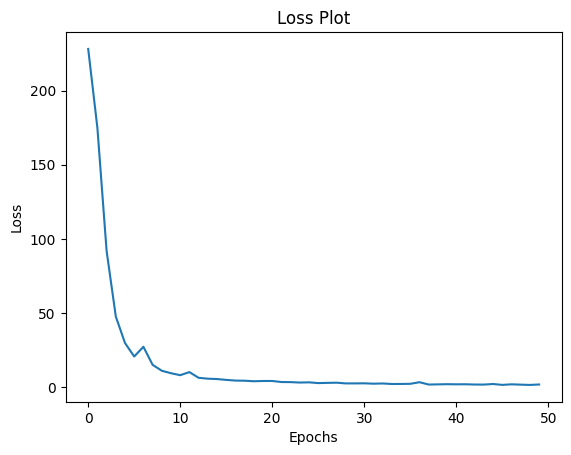

In [33]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

## 5. Validate

In [16]:
checkpoint_path = "./ckpt"
ckpt = tf.train.Checkpoint(feature_extractor=feature_extractor,
                           encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=3)

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print(ckpt_manager.latest_checkpoint)

./ckpt/ckpt-80


In [17]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = feature_extractor(temp_input)
#     img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index[' ']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        if tokenizer.index_word[predicted_id] == ' ':
            return result, attention_plot
        
        result.append(tokenizer.index_word[predicted_id])

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [18]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(1, len_result, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

Real Captcha: steps
Prediction Captcha: steps


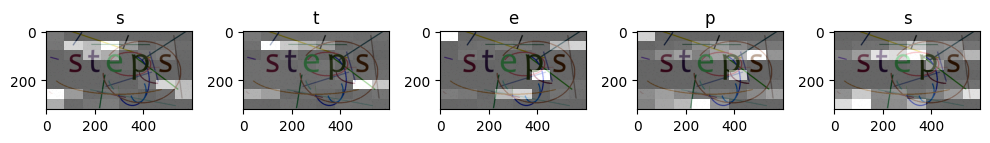

In [34]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_captcha = ''.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)
predict_captcha = ''.join(result)

print ('Real Captcha:', real_captcha)
print ('Prediction Captcha:', predict_captcha)
plot_attention(image, result, attention_plot)
# opening the image
# Image.open(img_name_val[rid])

In [35]:
from sklearn.metrics import accuracy_score

predict_target_val = []

for img_name in tqdm(img_name_val):
    result, attention_plot = evaluate(img_name)
    predict_captcha = ''.join(result)
    predict_target_val.append(predict_captcha)

accuracy = accuracy_score(target_val, predict_target_val)

print('Validate Accuracy: ', accuracy)

100%|██████████| 20000/20000 [24:17<00:00, 13.72it/s]

Validate Accuracy:  0.90575


## 6. Predict

In [36]:
img_name_test = [f'{data_dir}a{i}.png' for i in range(120000, 140000)]

predict_target_test = []

for img_name in tqdm(img_name_test):
    result, attention_plot = evaluate(img_name)
    predict_captcha = ''.join(result)
    predict_target_test.append(predict_captcha)

output_filename = 'Lab12-2_108032053.txt'
with open(output_filename, 'w') as file:
    for i, target in enumerate(predict_target_test):
        file.write(f'a{120000 + i} {target}\n')

100%|██████████| 20000/20000 [24:13<00:00, 13.76it/s]


## 7. Report

### Preprocess

我對這些captacha圖片的preprocess就只有先將圖片使用 `tf.image.decode_png` 做解碼，接著將原始大小為 600\*320 縮小成 300\*160 的大小，最後再用 `img = (img / 255) * 2 - 1` 將資料線性調整至 -1 ~ 1 之間。而 captcha 文字的部分，因為總共只有 26 個小寫的英文字母，再加上需要用來做 padding 來維持 output size 相同的 1 個字母，所以最後 vacabulary size 為 27。

### Model

Model 分成兩個部分，第一部分是使用 3 組 conv + maxpool 做成的 CNN 來取得圖片的 feature map，最後再將 output reshape 成 37\*2560。第二部分則是和範例 code 中相同，採用 CNN_Encoder + RNN_Decoder + BahdanauAttention 的結構，並將第一部分的 output 直接接上來預測出結果。

### Training

這邊的 loss function 我有做改寫，因為這邊的預測必須完全正確，不像 Caption 只需要接近就好，而且 padding 的位置也必須完全正確，因此不能使用 mask 來去除他的 loss，所以最後我就是直接使用 `SparseCategoricalCrossentropy(real, pred)` 並 reduce sum 作為 loss。接著在 training 的部分，我總共跑了 80 個 epoch，其中前 50 個 epoch 的 learning rate 設為 1e-3，而後面 30 個 epoch 則是減少到 1e-4，最終我在 validate 得到了 0.905 的準確度，剛好通過了 90% 的標準。